In [1]:
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm
#import colorcet as cc
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
landcolour = 'papayawhip'
plt.rcParams['font.size'] = 15

In [3]:
minoil = 3 # litres per grid cell

In [4]:
mesh = xr.open_dataset('~/Documents/MEOPAR/grid/mesh_mask201702.nc')
tmask = 1- mesh.tmask[0, 0]

In [6]:
data = xr.open_dataset('/home/sallen/Documents/MIDOSS/MIDOSS_aggregated_merged.nc')
data.OilWaterColumnOilVol_surface_conc

<xarray.DataArray 'OilWaterColumnOilVol_surface_conc' (RunId: 723, y: 270, x: 240)>
[46850400 values with dtype=float64]
Coordinates:
  * RunId    (RunId) object 'A-0' 'A-1' 'A-10' 'A-11' ... 'E-97' 'E-98' 'E-99'
  * y        (y) int64 500 501 502 503 504 505 506 ... 764 765 766 767 768 769
  * x        (x) int64 100 101 102 103 104 105 106 ... 334 335 336 337 338 339

In [24]:
oil = data.OilWaterColumnOilVol_surface_conc[:, 39] > minoil/1000.

In [150]:
myoil1 = data.OilWaterColumnOilVol_3D[11::12, 39]

In [151]:
myoil = myoil1 > minoil/1000.

In [152]:
oil_array = np.ma.masked_array(myoil, myoil < 0.001)

In [153]:
oil_array.shape

(14, 896, 396)

In [7]:
imin = 500
jmin = 100
imax = 770
jmax = 340

In [25]:
default = 240
oil_arrival = default * np.ones((896, 396))
for ii in range(imin, imax):
    if (int(ii/10)*10 == ii):
        print (ii)
    for jj in range(jmin, jmax):
        oil_arrival[ii, jj] = next((it for it, x in enumerate(oil[:, ii, jj]) if x), default)

        

500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760


In [26]:
print (oil_arrival.max()/24)

10.0


In [27]:
arrived = np.ma.masked_array(oil_arrival/24., oil_arrival/24. >= 10)


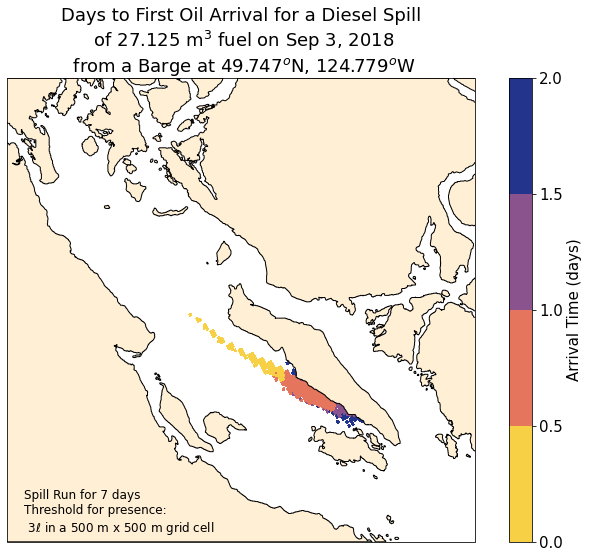

In [53]:
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)

bounds = np.arange(0, 2.5, 0.5)
norm = colors.BoundaryNorm(bounds, thermal_r_t.N)
C = ax.pcolormesh(
    mesh.nav_lon[1:, 1:], mesh.nav_lat[1:, 1:], arrived, 
    transform=crs.PlateCarree(), cmap=thermal_r_t, norm=norm
)
cb = fig.colorbar(C, ax=ax);
cb.set_label('Arrival Time (days)')
ax.set_title("Days to First Oil Arrival for a Diesel Spill\n of 27.125 m$^3$ fuel on Sep 3, 2018\n from a Barge at 49.747$^o$N, 124.779$^o$W");
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))
ax.text(-125.25, 49.32, f'Spill Run for 7 days\nThreshold for presence:\n {minoil}$\ell$ in a 500 m x 500 m grid cell',
       transform=crs.PlateCarree(), fontsize=12)
fig.tight_layout()
fig.savefig(f'SingleSpill_latlon_{minoil}.png', dpi=200)

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [42]:
minColor = 0.1
maxColor = 0.85
thermal_r_t = truncate_colormap(cm.thermal_r, minColor, maxColor)
mydiscrete = truncate_colormap(cm.thermal_r, 0.1, 0.85, 4)
#thermal_r_t.set_bad('k')

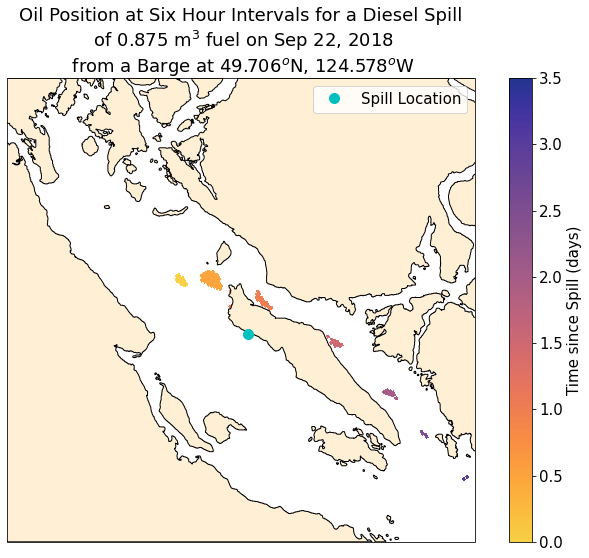

In [161]:
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
bounds = np.arange(0., 1.25, 0.125)
norm = colors.BoundaryNorm(bounds, thermal_r_t.N)

perday = 0.5

for day in [1, 2, 3, 4, 5, 6, 7]:
    C = ax.pcolormesh(
    mesh.nav_lon[1:-1, 1:-1], mesh.nav_lat[1:-1, 1:-1], perday*(day-1)*oil_array[day-1], vmin=0, vmax=3.5,
    transform=crs.PlateCarree(), cmap=thermal_r_t,
)
#    C = ax.contourf(mesh.nav_lon[1:-1, 1:-1], mesh.nav_lat[1:-1, 1:-1], 0.5*(day-1)*oil_array[day-1],
#    transform=crs.PlateCarree(), cmap=thermal_r_t, norm=norm
#)
#C = ax.pcolormesh(
#    mesh.nav_lon[1:, 1:], mesh.nav_lat[1:, 1:], arrived, vmin=0, vmax=7,
#    transform=crs.PlateCarree(), cmap=thermal_r_t
#)
ax.plot(-124.578, 49.706, 'co', zorder=3, markersize=10, transform=crs.PlateCarree(), label="Spill Location")
ax.legend(loc='upper right')
cb = fig.colorbar(C, ax=ax);
cb.set_label('Time since Spill (days)')
ax.set_title("Oil Position at Six Hour Intervals for a Diesel Spill\n of 0.875 m$^3$ fuel on Sep 22, 2018\n from a Barge at 49.706$^o$N, 124.578$^o$W");
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))
fig.tight_layout()
fig.savefig('SingleSpill_location_latlon.png')

In [62]:
for day in range(7, 0, -1):
    slot = day - 1
    print (day, oil_array[slot][oil_array[slot] == 1].count())

7 0
6 0
5 1
4 1
3 2
2 36
1 85


## Other Spills

In [54]:
data = xr.open_dataset('/home/sallen/Documents/MIDOSS/Visualization/Lagrangian_diesel-1_northern_strait_first30-1.nc')

In [55]:
oil = data.OilWaterColumnOilVol_3D[:, 39] > minoil/1000.

In [56]:
default = 240
oil_arrival = default * np.ones((896, 396))
for ii in range(imin, imax):
    if (int(ii/10)*10 == ii):
        print (ii)
    for jj in range(jmin, jmax):
        oil_arrival[ii, jj] = next((it for it, x in enumerate(oil[:, ii, jj]) if x), default)

500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760


In [57]:
arrived = np.ma.masked_array(oil_arrival/24., oil_arrival/24. >= 10)

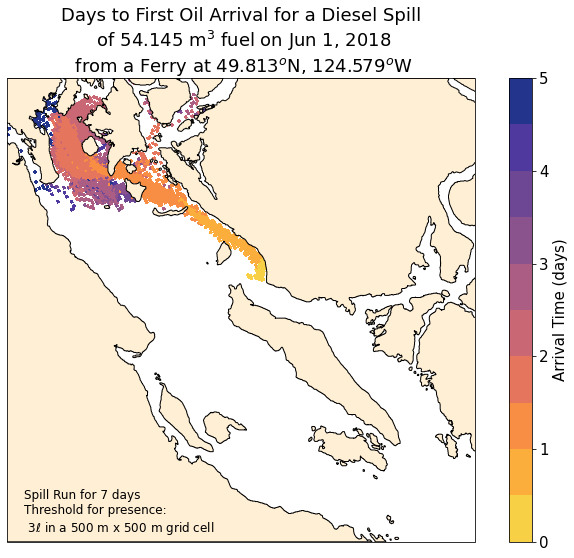

In [65]:
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)

bounds = np.arange(0, 5.5, 0.5)
norm = colors.BoundaryNorm(bounds, thermal_r_t.N)
C = ax.pcolormesh(
    mesh.nav_lon[1:, 1:], mesh.nav_lat[1:, 1:], arrived, 
    transform=crs.PlateCarree(), cmap=thermal_r_t, norm=norm
)
cb = fig.colorbar(C, ax=ax);
cb.set_label('Arrival Time (days)')
ax.set_title("Days to First Oil Arrival for a Diesel Spill\n of 69.565 m$^3$ fuel on Jun 1, 2018\n from a Ferry at 49.813$^o$N, 124.579$^o$W");
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))
ax.text(-125.25, 49.32, f'Spill Run for 7 days\nThreshold for presence:\n {minoil}$\ell$ in a 500 m x 500 m grid cell',
       transform=crs.PlateCarree(), fontsize=12)
fig.tight_layout()
fig.savefig(f'SingleSpill_1_latlon_{minoil}.png', dpi=200)

In [140]:
data = xr.open_dataset('/home/sallen/Documents/MIDOSS/Visualization/Lagrangian_diesel-2_northern_strait_first30-2.nc')

In [67]:
oil = data.OilWaterColumnOilVol_3D[:, 39] > minoil/1000.

In [68]:
default = 240
oil_arrival = default * np.ones((896, 396))
for ii in range(imin, imax):
    if (int(ii/10)*10 == ii):
        print (ii)
    for jj in range(jmin, jmax):
        oil_arrival[ii, jj] = next((it for it, x in enumerate(oil[:, ii, jj]) if x), default)

500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760


In [69]:
arrived = np.ma.masked_array(oil_arrival/24., oil_arrival/24. >= 10)

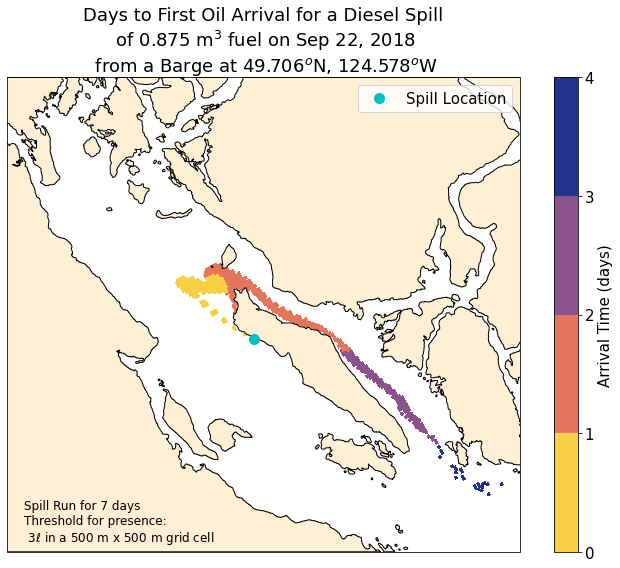

In [170]:
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9+0.1], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)

bounds = np.arange(0, 4.5, 1)
norm = colors.BoundaryNorm(bounds, thermal_r_t.N)
C = ax.pcolormesh(
    mesh.nav_lon[1:, 1:], mesh.nav_lat[1:, 1:], arrived, 
    transform=crs.PlateCarree(), cmap=thermal_r_t, norm=norm
)
ax.plot(-124.578, 49.706, 'co', zorder=3, markersize=10, transform=crs.PlateCarree(), label="Spill Location")
ax.legend(loc='upper right')
cb = fig.colorbar(C, ax=ax);
cb.set_label('Arrival Time (days)')
ax.set_title("Days to First Oil Arrival for a Diesel Spill\n of 0.875 m$^3$ fuel on Sep 22, 2018\n from a Barge at 49.706$^o$N, 124.578$^o$W");
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))
ax.text(-125.25, 49.32, f'Spill Run for 7 days\nThreshold for presence:\n {minoil}$\ell$ in a 500 m x 500 m grid cell',
       transform=crs.PlateCarree(), fontsize=12)
fig.tight_layout()
fig.savefig(f'SingleSpill_arrival_1_latlon_{minoil}.png')

In [79]:
print (arrived[(arrived < 10) & (arrived > 3.5)].count())

9


In [163]:
data = xr.open_dataset('/home/sallen/Documents/MIDOSS/Visualization/Lagrangian_diesel-98_north_strait_4th122-98.nc')

In [164]:
myoil1 = data.OilWaterColumnOilVol_3D[11::12, 39]

In [168]:
print (myoil.shape)

(6, 896, 396)


In [165]:
myoil = myoil1 > minoil/1000.

In [166]:
oil_array = np.ma.masked_array(myoil, myoil < 0.001)

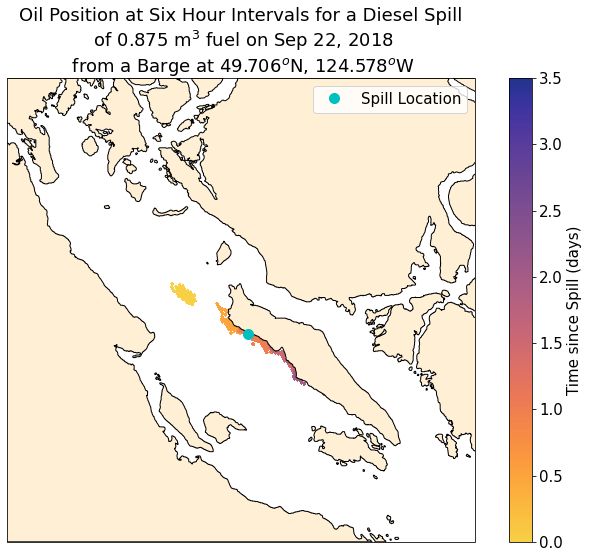

In [169]:
fig = plt.figure(figsize=(10, 8))
xlim, ylim = [-125.3, -123.9], [49.3, 50.2]
ax = plt.axes(projection=crs.Mercator(np.mean(xlim), *ylim))
ax.set_extent(xlim + ylim)
bounds = np.arange(0., 1.25, 0.125)
norm = colors.BoundaryNorm(bounds, thermal_r_t.N)

perday = 0.5

for day in [1, 2, 3, 4, 5]:
    C = ax.pcolormesh(
    mesh.nav_lon[1:-1, 1:-1], mesh.nav_lat[1:-1, 1:-1], perday*(day-1)*oil_array[day-1], vmin=0, vmax=3.5,
    transform=crs.PlateCarree(), cmap=thermal_r_t,
)
#    C = ax.contourf(mesh.nav_lon[1:-1, 1:-1], mesh.nav_lat[1:-1, 1:-1], 0.5*(day-1)*oil_array[day-1],
#    transform=crs.PlateCarree(), cmap=thermal_r_t, norm=norm
#)
#C = ax.pcolormesh(
#    mesh.nav_lon[1:, 1:], mesh.nav_lat[1:, 1:], arrived, vmin=0, vmax=7,
#    transform=crs.PlateCarree(), cmap=thermal_r_t
#)
ax.plot(-124.578, 49.706, 'co', zorder=3, markersize=10, transform=crs.PlateCarree(), label="Spill Location")
ax.legend(loc='upper right')
cb = fig.colorbar(C, ax=ax);
cb.set_label('Time since Spill (days)')
ax.set_title("Oil Position at Six Hour Intervals for a Diesel Spill\n of 0.875 m$^3$ fuel on Sep 22, 2018\n from a Barge at 49.706$^o$N, 124.578$^o$W");
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor=landcolour))
fig.tight_layout()
fig.savefig('SingleSpill_4_98_location_latlon.png')